# Modelling of interventions for TB in prisons

##### Alliance meeting Paraguay EUSAT-RCS consortium, 2024

Designed by Juan F. Vesga, 2024 

During this session we will examine the impact of interventions targeted at different steps in the TB cascade of care, for a hypotehtical setting with high levels of transmission in prisons. For this purpose we will use a pre-coded TB transmission model. Our model is coded in R and all available functions are available in the folders with this notebook. The practical is designed for a wider audience (i.e, no need to be fluent in R!) and focuses on understanding TB dynamics under different interventions. Howevere, it should also be a good resource for those already fammiliar with Rvprogramming language and an introductory gate for those aiming at learning more about TB modelling in R. 

**The Model**

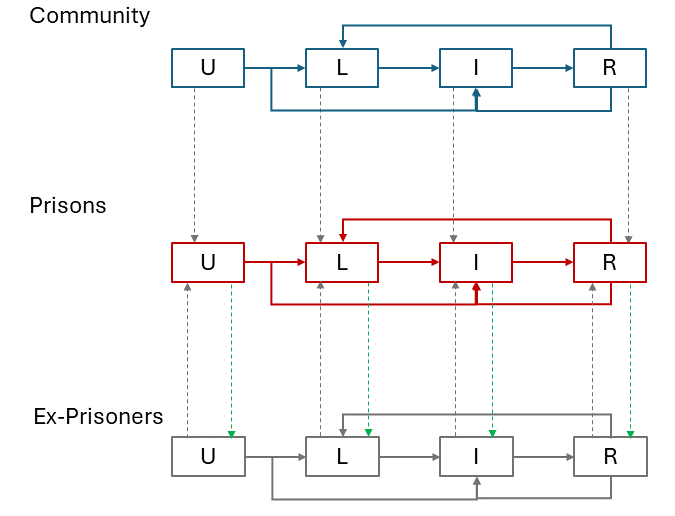

This model has three separate transmission environments: The community, prisons and ex-prisioner population. The three dimensions replicate the same mechanistic approach to TB transmission. This is, uninfected individuals (U) get infected at a rate lambda which is defined by a per-capita effectve contact rate (beta) and the time vafrying prevalence of TB infectious individuals. Once infected, individuals can either mpve into the latent TB infection compartment (L) or fast-track into the active TB compartment (I). Transitions from L into I occur at a much slower rate reflecting the remote source of TB incidence known from the literature. Active TB has an average duration of 3 years, after which individuals can either die from te disease or recover. The recovered compartment (R) allows for re-infection and also relapse. The re-infection process from R is mediated by some form of immunity acquired thorugh previous infection.   

In [ ]:
# Load necessary libraries
library(deSolve)
library(gridExtra)
library(ggplot2)
library(reshape)

In [ ]:
# Model Parameters
T.lfx    <- 72              # Life expectancy
T.dur    <- 3               # Duration of infectious period
mu       <- 1/T.lfx         # Background mortality rate
mu_tb    <- 0.5*1/T.dur     # TB mortality rate
fast     <- 0.1             # Fraction fast progressing to active TB
imm      <- 0.5             # Infectiousness decline (partial immunity)
relapse  <- 0.005           # Relapse rate
r_incar  <- 200/1e5         # Incarceration rate
r_reincar<- 1000/1e5        # Re-Incarceration rate
r_release<- 0.5             # release rate (1/mean term time) 
RRc      <- 2               # Ratio of increase in contact in prison relative to community
RRbreak_p<- 5               # relative increase in TB reactivation in prison
RRbreak_x<- 2               # relative increase in TB reactivation in prison

#Community params
beta     <- 5               # Transmission rate per capita
break_in <- 0.1*1/T.lfx     # Transition rate from latent to active disease
selfcure <- 0.5*1/T.dur     # Rate of spontaneous cure

#Prison params
beta_p     <- beta*RRc         # Transmission rate per capita
break_in_p <- break_in*RRbreak_p # Transition rate from latent to active disease
fast_p     <- 0.1             # Fraction fast progressing to active TB
selfcure_p <- 0.5*1/T.dur      # Rate of spontaneous cure

#Prison params
beta_x     <- beta             # Transmission rate per capita
break_in_x <- break_in*RRbreak_x # Transition rate from latent to active disease
selfcure_x <- 0.5*1/T.dur      # Rate of spontaneous cure


In [ ]:
# Load the R functions for TB transmission in prisons and for analysisng interventions
source("R/TB_prison.r")
source("R/useful_functions.r")

In [ ]:
t.intervention <- 400      # years of simulation
t.scale        <- 3        # Scaling up time of interventions
times <- seq(0, t.intervention, by = 1)          # time scale

In [ ]:

# Create
params <- c(
    break_in = break_in,
    break_in_p = break_in_p,
    selfcure = selfcure, 
    selfcure_p = selfcure_p, 
    mu = mu, 
    mu_tb = mu_tb,
    beta = beta,
    beta_p = beta_p, 
    fast = fast, 
    fast_p = fast_p, 
    imm = imm, 
    relapse = relapse,
    r_incar=r_incar,
    r_reincar=r_reincar,
    r_release=r_release) 

# Initial Conditions
N  <- 1                    # Total population equal to unity 
I0 <- 1e-6                 # TB seed at time 0
Np  <- 0.005               # Total population equal to unity 
I0p <- 0.005*1e-6*10        # TB seed at time 0
Nx  <- 0.005*0.5           # Total population equal to unity 
I0x <- 0.005*0.5*1e-6*5        # TB seed at time 0


xstart <- data.frame(
                     U = N-I0-Np-Nx,
                     L = 0,
                     I = I0,  
                     R = 0,
                     Ux = Nx-I0x,
                     Lx = 0,
                     Ix = I0x,  
                     Rx = 0,
                     Up = Np-I0p,
                     Lp = 0,
                     Ip = I0p,  
                     Rp = 0,
                     Incidence = 0, 
                     Irecent = 0, 
                     Iremote = 0,
                     Incidence_x = 0, 
                     Irecent_x = 0, 
                     Iremote_x = 0,
                     Incidence_p = 0, 
                     Irecent_p = 0, 
                     Iremote_p = 0)         

In [ ]:
out0  <- get_intervention(xstart, params, NA, times, NA, NA, TB_prison,
"Initial", NA) 

# plot
out0$inc_all

In [ ]:
# Function handles

fx_basic<-TB_prison
fx_scale<-function(t, state, parameters) scale_up(t, state, parameters,t.interv,params,fx_basic)

In [ ]:
## Simulation 0
# Project a baseline
int_name   <- "Baseline"

#Initial conditions (starting in 2019)
sfin       <- tail(out0$out,1)                             
params_base<- params
times_new  <- seq(t.intervention, t.intervention+25 , by=1)
t.interv   <- c(times_new[2], times_new[2]+t.scale)

#Run model
data0<-get_intervention(sfin, params_base, params_base,times_new,
                             NA, fx_scale,fx_basic, "Baseline", NA) 
#Plot
grid.arrange(data0$inc_c ,data0$inc_p )
 



In [ ]:

fx_basic <- TB_prison
fx_scale <- function(t, state, parameters) scale_up(t, state, parameters, t.interv, params, fx_basic)

In [ ]:
int_name    <- "Baseline"

# Initial conditions (starting in 2019)
sfin        <- tail(out0$out, 1)                             
params_base <- params
times_new   <- seq(t.intervention, t.intervention + 25, by = 1)
t.interv    <- c(times_new[2], times_new[2] + t.scale)

# Run model
data0 <- get_intervention(sfin, params_base, params_base, times_new, NA,
                          fx_scale, fx_basic, "Baseline", NA) 
# Plot
grid.arrange(data0$inc_p, data0$inc_c)

In [ ]:
## Simulation 1
# An Intervention simulating introduction of treatment
int_name   <- "Treatment"

#Update parameter results data frame to append new results
params_1 <-params_base
data_stub<-data0$data


# Change parameters for intervention
T.cs <- 1     # Time delay (yrs) between developing symptoms and seeking for care
pDx  <- 0.95   # Probability of being diagnosed once sought care
pTx  <- 0.95   # probability of receiving correct Tx if diagnosed
T.rTx<- 0.5 # 6 months treatment duration

Tx <-pDx*pTx*(1/(T.cs+T.rTx))

params_1["selfcure"]<-selfcure + Tx

data1<-get_intervention(sfin, params_1, params_base,times_new,
                       t.interv, fx_scale,fx_basic, int_name, data_stub) 

p1<-data1$lines +
  # EndTb
  geom_hline(yintercept=200*0.1, linetype="dashed", color = "black", size=1)+
  # Elimination
  geom_hline(yintercept=0.1/1e5, linetype="dashed", color = "red", size=1)


grid.arrange(data1$inc_c ,data1$inc_p )

In [ ]:
## Simulation 2
# An Intervention simulating demand generation
int_name   <- "Demand generation"

#Update parameter results data frame to append new results
params_2 <-params_1
data_stub<-data1$data

# Change parameters for intervention
T.cs <-  1*(1-0.75)    # Time delay (yrs) between developing symptoms and seeking for care
pDx  <-  0.95     # Probability of being diagnosed once sought care
pTx  <-  0.95     # probability of receiving correct Tx if diagnosed
T.rTx<-  0.5     # 6 months treatment duration

Tx <-pDx*pTx*(1/(T.cs+T.rTx))

params_2["selfcure"]<-selfcure + Tx

data2<-get_intervention(sfin, params_2, params_BASE,times_new,
                       t.interv, fx_scale,fx_basic, int_name, data_stub) 

# p1<-data2$lines +
#   # EndTb
#   geom_hline(yintercept=Inc.country*0.1, linetype="dashed", color = "black", size=1)+
#   # Elimination
#   geom_hline(yintercept=0.1/1e5, linetype="dashed", color = "red", size=1)


grid.arrange(data2$inc_c ,data2$inc_p )

In [ ]:
## Simulation 3
int_name<-"Transmission stop"

#Update parameter results data frame to append new results
params_3 <-params_2
data_stub<-data2$data

# An Intervention simulating transmission reduction

params_3["beta"]<-0


data3<-get_intervention(sfin, params_3, params_base,times_new,
                       t.interv, fx_scale,fx_basic, int_name, data_stub) 

p1<-data3$inc_c +
  # EndTb
  geom_hline(yintercept=210*0.1, linetype="dashed", color = "black", size=1)+
  # Elimination
  geom_hline(yintercept=0.1/1e5, linetype="dashed", color = "red", size=1)


grid.arrange(p1 ,data3$inc_p )


In [ ]:
## Simulation 4
# An Intervention simulating LTBI treatment
int_name<- "Prevention"

#Update parameter results data frame to append new results
params_4 <-params_3
data_stub<-data3$data

params_4["break_in"]<-0.01*(1/T.lfx)

data4<-get_intervention(sfin, params_4, params_base,times_new,
                       t.interv, fx_scale,fx_basic, int_name, data_stub) 

p1<-data4$inc_c +
  # EndTb
  geom_hline(yintercept=210*0.1, linetype="dashed", color = "black", size=1)+
  # Elimination
  geom_hline(yintercept=0.1/1e5, linetype="dashed", color = "red", size=1)


grid.arrange(p1 ,data4$inc_p )